In [34]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt 
import numpy as np
from tqdm import tqdm

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
X shape: (55000, 784)
Y shape: (55000, 10)



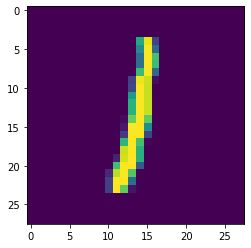

In [35]:
mnist = input_data.read_data_sets("MNIST_data", one_hot=True)
# print out shapes and example im
print("X shape: {}".format(mnist.train.images.shape))
print("Y shape: {}".format(mnist.train.labels.shape))
n = 28
n_classes = 10
print()
plt.imshow(mnist.train.images[4].reshape(28,28))

In [36]:
# weights and biases definition
W = {'W_0': tf.get_variable('W0', shape=(3,3,1,16), initializer=tf.contrib.layers.xavier_initializer()),
       'W_1': tf.get_variable('W1', shape=(3,3,16,64), initializer=tf.contrib.layers.xavier_initializer()),
       'W_2': tf.get_variable('W2', shape=(3,3,64,128), initializer=tf.contrib.layers.xavier_initializer()),
       'W_3': tf.get_variable('W3', shape=(3,3,128,256), initializer=tf.contrib.layers.xavier_initializer()),
       'W_4': tf.get_variable('W4', shape=(256 * 2 * 2,128), initializer=tf.contrib.layers.xavier_initializer()),
       'W_5': tf.get_variable('W5', shape=(128,n_classes), initializer=tf.contrib.layers.xavier_initializer()),
      }
b = {'B_0': tf.get_variable('B0', shape=(16), initializer=tf.contrib.layers.xavier_initializer()),
       'B_1': tf.get_variable('B1', shape=(64), initializer=tf.contrib.layers.xavier_initializer()),
       'B_2': tf.get_variable('B2', shape=(128), initializer=tf.contrib.layers.xavier_initializer()),
       'B_3': tf.get_variable('B3', shape=(256), initializer=tf.contrib.layers.xavier_initializer()),
       'B_4': tf.get_variable('B4', shape=(128), initializer=tf.contrib.layers.xavier_initializer()),
       'B_5': tf.get_variable('B5', shape=(n_classes), initializer=tf.contrib.layers.xavier_initializer()),
      }

In [37]:
sess = tf.InteractiveSession()

/Users/arjunarora/anaconda3/envs/verkada/lib/python3.7/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [38]:
def trainModel(Model,X,Y,lr = 0.001,batch_sz = 128,num_epochs = 100):
    if len(X.shape) < 4: 
        X = X.reshape(-1, 28, 28, 1)
    x = tf.placeholder("float", [None, n,n,1])
    y = tf.placeholder("float", [None, n_classes])
    
    pred = Model(x)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
    optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize(cost)
    
    num_correct = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(num_correct, tf.float32))
    saver = tf.train.Saver()
    train_loss = []
    train_accuracy = []
    init = tf.global_variables_initializer()
    
    batchLen = len(X) // batch_sz
    init = tf.initialize_all_variables()
    sess.run(init)
    for i in tqdm(range(num_epochs)):
        for j in range(batchLen):
            batch_X = X[j*batch_sz:min((j+1)*batch_sz,len(X))]
            batch_Y = Y[j*batch_sz:min((j+1)*batch_sz,len(Y))]

            opt = sess.run(optimizer, feed_dict={x: batch_X,y: batch_Y})
            loss,acc = sess.run([cost, accuracy], feed_dict={x: batch_X,y: batch_Y})
        train_loss.append(loss)
        train_accuracy.append(acc)
        print("Epoch: {}, Loss: {}, Accuracy: {}".format(i + 1,loss,acc))
    save_path = saver.save(sess, "./model.ckpt")
    return train_loss,train_accuracy

In [39]:
def testModel(Model,test_X,test_Y):
#     tf.reset_default_graph()
    if len(test_X.shape) < 4: 
        test_X = test_X.reshape(-1, 28, 28, 1)
    x = tf.placeholder("float", [None, n,n,1])
    y = tf.placeholder("float", [None, n_classes])
    pred = Model(x)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
    num_correct = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
    
    accuracy = tf.reduce_mean(tf.cast(num_correct, tf.float32))
    saver = tf.train.Saver()
    test_loss = []
    test_accuracy = []
#     init = tf.initialize_all_variables()
#     sess.run(init)
    test_loss,test_acc = sess.run([cost,accuracy], feed_dict={x: test_X,y : test_Y})
    saver.restore(sess, "./model.ckpt")
    print("Loss: {}, Accuracy: {}".format(test_loss,test_acc))
    return test_loss,test_acc

In [40]:
class CNN(object):
    def __init__(self,W,b):
        self.W = W
        self.b = b
    def conv(self,x,W_i,b_i,s = 1):
        x = tf.nn.bias_add(tf.nn.conv2d(x, W_i,[1,s,s,1],padding='SAME'),b_i)
        return tf.nn.leaky_relu(x)
    def maxpool(self,x):
        kernel_sz= [1,2,2,1]
        return tf.nn.max_pool(x,kernel_sz,kernel_sz,padding='SAME')
    def dense(self,x,W_i,b_i):
        return tf.nn.leaky_relu(tf.add(tf.matmul(x,W_i),b_i))
    def __call__(self,x):
        c0 = self.conv(x, self.W['W_0'], self.b['B_0']) # 28 x 28 x 16
        m0 = self.maxpool(c0)
        
        c1 = self.conv(m0,self.W['W_1'],self.b['B_1']) # 14 x 14 x 64
        m1 = self.maxpool(c1)
        
        c2 = self.conv(m1,self.W['W_2'],self.b['B_2']) # 7 x 7 x 128
        m2 = self.maxpool(c2)
        
        c3 = self.conv(m2,self.W['W_3'],self.b['B_3']) # 4 x 4 x 256
        m3 = self.maxpool(c3) # 2 x 2 x 256

        d0 = tf.reshape(m3, [-1, self.W['W_4'].get_shape().as_list()[0]]) # (256 x 2 x 2, 1)
        d0 = self.dense(d0,self.W['W_4'], self.b['B_4']) # (128, 1)

        d1 = self.dense(d0,self.W['W_5'],self.b['B_5']) # (10,1)
        return d1 
model = CNN(W,b)

In [45]:
trainModel(model,mnist.train.images[:2000],mnist.train.labels[:2000],num_epochs = 10)

 10%|█         | 1/10 [00:01<00:12,  1.44s/it]

Epoch: 1, Loss: 2.1018667221069336, Accuracy: 0.28125


 20%|██        | 2/10 [00:02<00:11,  1.44s/it]

Epoch: 2, Loss: 0.8963441848754883, Accuracy: 0.7109375


 30%|███       | 3/10 [00:04<00:09,  1.43s/it]

Epoch: 3, Loss: 0.5337953567504883, Accuracy: 0.8125


 40%|████      | 4/10 [00:05<00:08,  1.42s/it]

Epoch: 4, Loss: 0.41034185886383057, Accuracy: 0.859375


 50%|█████     | 5/10 [00:07<00:07,  1.41s/it]

Epoch: 5, Loss: 0.31386834383010864, Accuracy: 0.90625


 60%|██████    | 6/10 [00:08<00:05,  1.40s/it]

Epoch: 6, Loss: 0.30495354533195496, Accuracy: 0.8984375


 70%|███████   | 7/10 [00:09<00:04,  1.40s/it]

Epoch: 7, Loss: 0.26879584789276123, Accuracy: 0.9296875


 80%|████████  | 8/10 [00:11<00:02,  1.40s/it]

Epoch: 8, Loss: 0.3514832854270935, Accuracy: 0.875


 90%|█████████ | 9/10 [00:12<00:01,  1.41s/it]

Epoch: 9, Loss: 0.18722420930862427, Accuracy: 0.9375


100%|██████████| 10/10 [00:14<00:00,  1.41s/it]

Epoch: 10, Loss: 0.1065874993801117, Accuracy: 0.9765625


([2.1018667,
  0.8963442,
  0.53379536,
  0.41034186,
  0.31386834,
  0.30495355,
  0.26879585,
  0.3514833,
  0.18722421,
  0.1065875],
 [0.28125,
  0.7109375,
  0.8125,
  0.859375,
  0.90625,
  0.8984375,
  0.9296875,
  0.875,
  0.9375,
  0.9765625])

In [46]:
testModel(model,mnist.test.images,mnist.test.labels)

INFO:tensorflow:Restoring parameters from ./model.ckpt
Loss: 0.17222943902015686, Accuracy: 0.9473000168800354


(0.17222944, 0.9473)

In [ ]:
testModel(model,mnist.train.images,mnist.train.labels)

In [ ]:
v1 = tf.get_variable("v1", shape=[3], initializer = tf.zeros_initializer)
v2 = tf.get_variable("v2", shape=[5], initializer = tf.zeros_initializer)

inc_v1 = v1.assign(v1+1)
dec_v2 = v2.assign(v2-1)

# Add an op to initialize the variables.
init_op = tf.global_variables_initializer()

# Add ops to save and restore all the variables.
saver = tf.train.Saver()

# Later, launch the model, initialize the variables, do some work, and save the
# variables to disk.
with tf.Session() as sess:
  sess.run(init_op)
  # Do some work with the model.
  inc_v1.op.run()
  dec_v2.op.run()
  # Save the variables to disk.
  save_path = saver.save(sess, "/tmp/model.ckpt")
  print("Model saved in path: %s" % save_path)

In [ ]:
tf.reset_default_graph()

# Create some variables.
v1 = tf.get_variable("v1", shape=[3])
v2 = tf.get_variable("v2", shape=[5])

# Add ops to save and restore all the variables.
saver = tf.train.Saver()

# Later, launch the model, use the saver to restore variables from disk, and
# do some work with the model.
with tf.Session() as sess:
  # Restore variables from disk.
  saver.restore(sess, "/tmp/model.ckpt")
  print("Model restored.")
  # Check the values of the variables
  print("v1 : %s" % v1.eval())
  print("v2 : %s" % v2.eval())